<a href="https://colab.research.google.com/github/brenoskuk/image_processing_exercises/blob/master/Emotion_recognition_facial_landmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Emotion Recognition based on facial landmarks**

This part of the practical session is about **emotion recognition** based on facial landmarks. We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.

Please answer to all questions and complete the code where you see **XXXXXXXXXXXXX**

**Deadline**: Upload this notebook, the one about Toy Examples and the answers to the theoretical questions as a single .zip file to the Site Pédagogique before the 5th of February 2020 (23h59). Name it as 'TP1-IMA205-YOUR-SURNAME.zip'.

First of all, we need to load the data. In Google Colab, we can load from Google Drive or from our local machine. Since it's faster from Google Drive, let's load them from (my) Google Drive, using the following code.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
dest_path='./data/Data_FEI.npz')
gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
dest_path='./data/facial_landmarks_68markup.jpg')

Otherwise, you can also load them from your local machine using the following code

In [ ]:
"""
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""      

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

Let's load the Python packages containing the functions needed for the practical session.

In [ ]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

We also load a user-defined function useful for plotting the confusion matrix

In [ ]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Now, let's load the data. 

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two picture will be different with therefore different landmark position. However, after a GPA, the two landmark positions should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [ ]:
# Parameters
dim=2 # dimension   
# Loading data
Working_directory="./data/" 
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks   
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = X.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

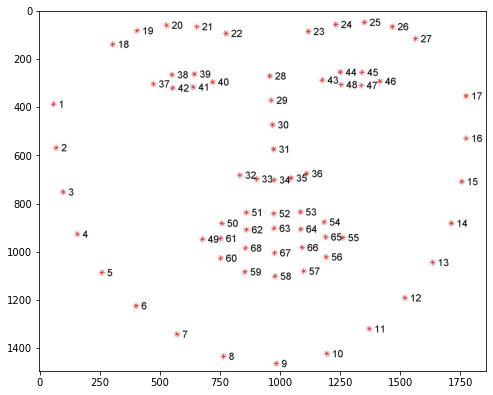

In [ ]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

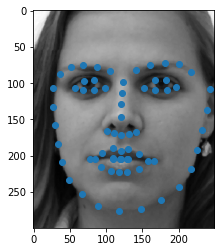

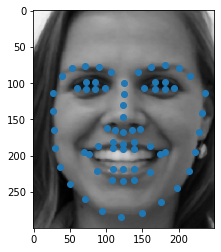

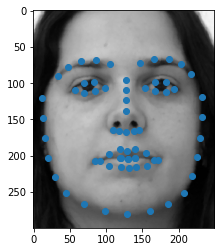

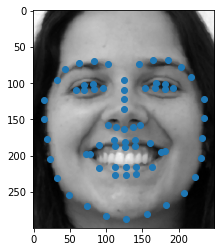

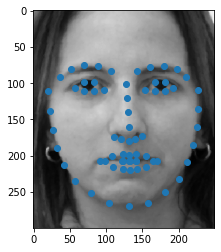

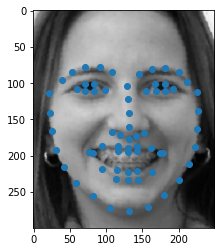

In [ ]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()



---



**Question**: after plotting the first 6 images of the data-set, what do you notice ? Do you notice a regular pattern ? Do you think that it would be worth it to randomly shuffle the data ?

**Answer**: Images of the same person are grouped together and are odereded by emotion. Shuffling the data would depend of what we want to achieve with the images. For instance, if we want to tell appart if the same person is happy or neutral, it would be interesting to maintain the two images together. If we want to generally tell emotions of a picture, it is interesting to suffle all images. Also, images seem to be separated by gender.


---



In [ ]:
# Shuffle data randomly. Hint: Use np.random.shuffle
shuffle_order = np.arange(N)
np.random.shuffle(shuffle_order)
# Use as new variables
XpGPA=XGPA[shuffle_order]
Xp=X[shuffle_order]
Yp=Y[shuffle_order]
Imagesp=Images[shuffle_order]
Xmean = np.mean(XpGPA,axis=0) # Compute average
Namesp=Names[shuffle_order] 

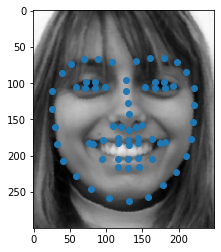

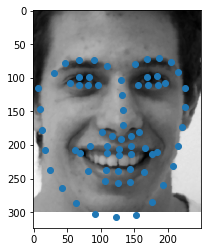

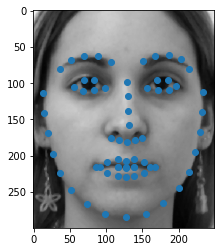

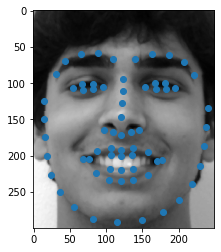

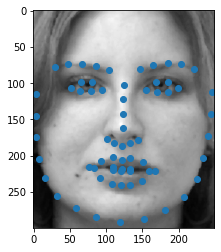

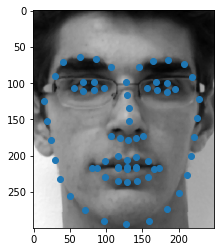

In [ ]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xp[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()



---



Among the loaded data, we also have aligned landmarks after a Generalized Procrustes Analysis. 


**Question**: Check them and compare them with the landmarks before alignement. Describe the differences.

**Answer**: Landmarks before alignment exibit greater variance, with many points invading the region of another. There is also a greater difference between the neutral and happy landmarks, possibly because of movement relative to the camera.  After allignment points tend to stay on a cluster near the average. 

In the following, we will use the landmarks after GPA (*XpGPA*)




---



Text(0.5, 1.0, 'Landmarks BEFORE alignement (GPA)')

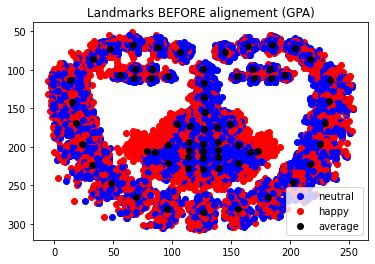

In [ ]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis() 
plt.title('Landmarks BEFORE alignement (GPA)')

Text(0.5, 1.0, 'Landmarks AFTER alignement (GPA)')

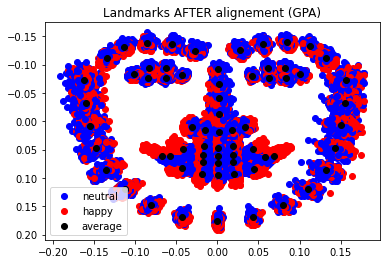

In [ ]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()   
plt.title('Landmarks AFTER alignement (GPA)')



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the (aligned) landmarks of every subject and the landmarks of the average configuration. Please remember to use XpGPA.



---



In [ ]:
# Compute distances from the average configuration (features)
from sklearn.metrics.pairwise import paired_distances

x_avg=Xmean[::2]
y_avg=Xmean[1::2]
xy_avg = np.array([[x_avg[j],y_avg[j]] for j in range(M)])

X_mean_dist=[]

for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    xy = np.array([[x[j],y[j]] for j in range(M)])
    dist_xy_avg = paired_distances(xy,xy_avg)
    X_mean_dist.append(dist_xy_avg)

dist_average = np.array(X_mean_dist)

dist_average.shape


(400, 68)

---

**Question**: One usual question in Machine Learning is, do we need to scale/normalize the features ? What do you think ? Should we do it in this case ? Compute both scaled and normalized data.

**Answer**: It would be a good procedure. In the case of euclidian distances, we can observe a point whose euclidian distance is very important in defining emotion but it's value is smaller that other more irrelevant points.
Also, the differences are quite small and normalization is interesting. 
When we add other features it will be necessary to normalize and standarize.

In [ ]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
scaler.fit(dist_average)
dist_average_scale=scaler.transform(dist_average)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
minmaxscaler = MinMaxScaler()
minmaxscaler.fit(dist_average)
dist_average_minmax_scale=minmaxscaler.transform(dist_average)

In [ ]:
dist_average_scale

array([[-1.41613119, -1.44633803, -1.2492757 , ...,  1.07504041,
         0.94049656,  0.95806808],
       [-1.13797362, -1.30634112, -1.27015439, ...,  2.44028635,
         2.44716649,  2.48135294],
       [-1.65577751, -1.4529713 , -1.27499962, ..., -0.92074342,
        -1.68225776, -1.2763328 ],
       ...,
       [ 1.45478974,  1.47948682,  1.25152649, ...,  0.92619864,
         0.64777032,  0.49559008],
       [-0.73362518, -1.12692983, -1.58695335, ..., -0.33666245,
        -0.71674209, -0.8547107 ],
       [-0.62662532, -0.66960445, -0.56682237, ..., -0.17644732,
         0.36203145,  0.82345043]])

Let's divide the data-set into Training and Test sets using original, scaled and normalized data.

In [ ]:
# Create training and test set
#X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)

def create_sets(dist_average, Yp):
  X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_sets(dist_average, Yp)
X1_train, X1_test, y1_train, y1_test = create_sets(dist_average_scale, Yp)
X2_train, X2_test, y2_train, y2_test = create_sets(dist_average_minmax_scale, Yp)



---



Let's try to fit LDA to all training sets and predict the error on their respective test sets. 

**Question**: Compare the performances between original, scaled and normalized data. Comment the results.

**Answer**: The performances we see in the confusion matrices are the same. This implies that normalization and standarization weren't necessary.

---



Fitting LDA to training set
done in 0.039s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

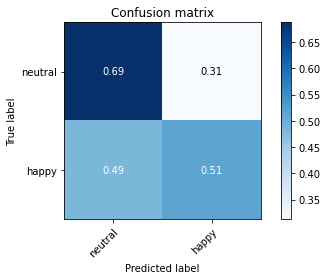

In [ ]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to standarized training set
done in 0.009s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

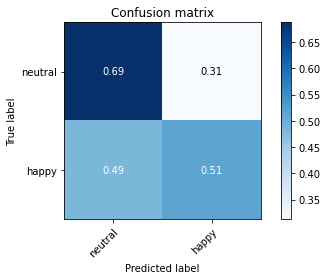

In [ ]:
# Fitting LDA to standarized data
print("Fitting LDA to standarized training set")
t0 = time()
lda1 = LinearDiscriminantAnalysis()
lda1.fit(X1_train, y1_train)
y1_pred = lda1.predict(X1_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y1_test, y1_pred))

# Compute confusion matrix
cnf_matrix1 = confusion_matrix(y1_test, y1_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=class_names, normalize=True)
plt.show()

Fitting LDA to normalized training set
done in 0.009s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

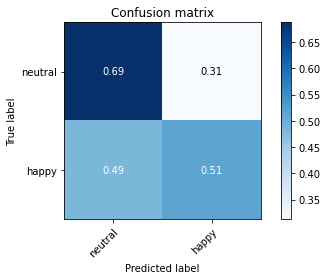

In [ ]:
# Fitting LDA to standarized data
print("Fitting LDA to normalized training set")
t0 = time()
lda2 = LinearDiscriminantAnalysis()
lda2.fit(X2_train, y2_train)
y2_pred = lda2.predict(X2_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y2_test, y2_pred))

# Compute confusion matrix
cnf_matrix2 = confusion_matrix(y2_test, y2_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names, normalize=True)
plt.show()



---



We can then use the function 'cross_val_score' to compute the CV score. Let's use all methods seen today. 

**Question**: compare the performances between original, scaled and normalized data



---






In [ ]:
# Cross-validation for Model Assessment
def many_fittings(dist_average,Yp):
  # Fitting LDA
  print("Fitting LDA")
  t0 = time()
  lda = LinearDiscriminantAnalysis()
  lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
  print("done in %0.3fs" % (time() - t0))
  print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

  # Fitting QDA
  print("Fitting QDA")
  t0 = time()
  qda = QuadraticDiscriminantAnalysis()
  qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
  print("done in %0.3fs" % (time() - t0))
  print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

  # Fitting Logistic-regression
  print("Fitting Logistic Regression")
  t0 = time()
  logit = LogisticRegression(solver='lbfgs')
  logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
  print("done in %0.3fs" % (time() - t0))
  print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

  # Fitting Naive-Bayes
  print("Fitting Naive-Bayes")
  t0 = time()
  GNB = GaussianNB()
  GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
  print("done in %0.3fs" % (time() - t0))
  print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

  # Fitting K-nearest neighbour
  print("Fitting K-nearest neighbour")
  t0 = time()
  neigh = KNeighborsClassifier(n_neighbors=7)
  neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
  print("done in %0.3fs" % (time() - t0))
  print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

In [ ]:
# fits with initial data
print ("Working with initial data: ")
many_fittings(dist_average,Yp)
# fits with standarized data
print ("\n\nWorking with standarized data: ")
many_fittings(dist_average_scale,Yp)
# fits with normalized data
print ("\n\nWorking with normalized data: ")
many_fittings(dist_average_minmax_scale,Yp)

Working with initial data: 
Fitting LDA
done in 0.053s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.041s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.029s
 Average and std CV score : 0.5349999999999999 +- 0.0483476990145343
Fitting Naive-Bayes
done in 0.011s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.067s
 Average and std CV score : 0.6399999999999999 +- 0.06294839156007086


Working with standarized data: 
Fitting LDA
done in 0.053s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.042s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.170s
 Average and std CV score : 0.55 +- 0.01767766952966367
Fitting Naive-Bayes
done in 0.011s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.066s
 Average and st



---



In the previous example we have fixed the hyper-parameter K to 3. We coudl use CV to find the best value.



---



The best K is 7  with an average validation score equal to  0.6399999999999999


Text(0, 0.5, 'CV Validation Score')

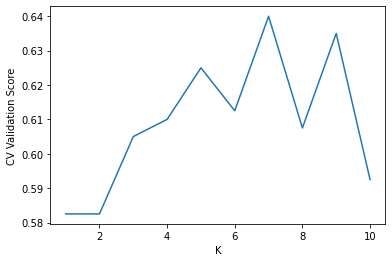

In [ ]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



The best K is 5  with an average validation score equal to  0.6044025157232704
The test score is 0.6590909090909091


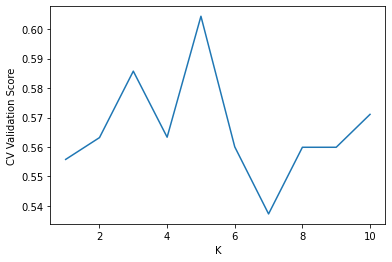

In [ ]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))



---



**Question**: Comment the results of the two previosu experiments. What about the best K and validation error ? Are the results the same ? Why in your opinion ?

**Answer**: 
The results are the same for the methods that have a closed formula for obtaining parameteres. This is due to the fact that the scaling are linear operations. In the case of  those that simply compare a treshold for making a prediction. This is not the cse for K-nearest and Fitting Logistic Regression.

Also, the results indicate that the features used aren't good descriptors as the best result is obtained by the optimization of K-nearest with K=7 and isn't satisfying.

---





---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [ ]:
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))

x_avg=Xmean[::2]
y_avg=Xmean[1::2]
xy_avg = np.array([[x_avg[j],y_avg[j]] for j in range(M)])


# Calculates features for each image

for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    xy = np.array([[x[j],y[j]] for j in range(M)])         
    m_distances = np.linalg.norm(xy - xy[:,None], axis=-1)  
    feats = np.array((m_distances[np.triu_indices(M, k = 1)]))
    dist_combination[i]=feats



**Question**: As before, should we scale/normalize the data ? 

**Answer**: It would be a good procedure. But results don't change. Same reasons as before. 

In [ ]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
scaler.fit(dist_combination)
dist_combination_scale=scaler.transform(dist_combination)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
minmaxscaler = MinMaxScaler()
minmaxscaler.fit(dist_combination)
dist_combination_minmax_scale=minmaxscaler.transform(dist_combination)

**Question**: Use the classification algorithms seen before to test the discriminative power of the new features. 

In [ ]:
# fits with initial data
print ("Working with initial data: ")
many_fittings(dist_combination,Yp)
# fits with standarized data
print ("\n\nWorking with standarized data: ")
many_fittings(dist_combination_scale,Yp)
# fits with normalized data
print ("\n\nWorking with normalized data: ")
many_fittings(dist_combination_minmax_scale,Yp)

Working with initial data: 
Fitting LDA
done in 1.600s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting QDA


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.842s
 Average and std CV score : 0.6175 +- 0.060518592184550996
Fitting Logistic Regression
done in 0.343s
 Average and std CV score : 0.9475 +- 0.019999999999999976
Fitting Naive-Bayes
done in 0.087s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting K-nearest neighbour
done in 0.880s
 Average and std CV score : 0.9399999999999998 +- 0.021505813167606556


Working with standarized data: 
Fitting LDA
done in 1.521s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting QDA


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.859s
 Average and std CV score : 0.6325000000000001 +- 0.06828250141873835
Fitting Logistic Regression
done in 0.741s
 Average and std CV score : 0.9625 +- 0.0262202212042538
Fitting Naive-Bayes
done in 0.083s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting K-nearest neighbour
done in 0.897s
 Average and std CV score : 0.9349999999999999 +- 0.020000000000000007


Working with normalized data: 
Fitting LDA
done in 1.534s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting QDA


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.836s
 Average and std CV score : 0.6599999999999999 +- 0.0526782687642637
Fitting Logistic Regression
done in 0.711s
 Average and std CV score : 0.975 +- 0.032596012026013255
Fitting Naive-Bayes
done in 0.090s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting K-nearest neighbour
done in 0.902s
 Average and std CV score : 0.9400000000000001 +- 0.018371173070873825




---



mmmm it seems that some variables are collinear. Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy. We could use a very well-known technique called PCA (Principal Component Analysis). We will see it in few lectures...



---



In [ ]:
# We could use PCA to map the data to a new coordiante system where the new variables would be orthogonal among each other. (so no more collinear...)
pca = decomposition.PCA(n_components=0.9) # use number of components take explain 90% of variability
pca.fit(dist_combination)
dist_combination_pca = pca.transform(dist_combination)  

print('Number of subjects N is: ', dist_combination_pca.shape[0], ' ; number of features is: ',  dist_combination_pca.shape[1] )

Number of subjects N is:  400  ; number of features is:  8


**Question**: Test the predictive power of the new features

**Answer**: It has been inproved!

In [ ]:
# fits with initial data
print ("Working with PCA features: ")
many_fittings(dist_combination_pca,Yp)

Working with PCA features: 
Fitting LDA
done in 0.022s
 Average and std CV score : 0.9525 +- 0.024238399287081668
Fitting QDA
done in 0.010s
 Average and std CV score : 0.97 +- 0.032210246816812824
Fitting Logistic Regression
done in 0.030s
 Average and std CV score : 0.9475 +- 0.019999999999999976
Fitting Naive-Bayes
done in 0.010s
 Average and std CV score : 0.9524999999999999 +- 0.022912878474779203
Fitting K-nearest neighbour
done in 0.033s
 Average and std CV score : 0.9375 +- 0.017677669529663688




---


A second solution, would be to manually select few landmarks



---



In [ ]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  12


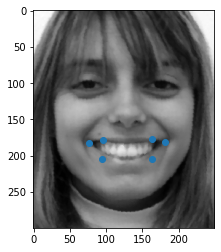

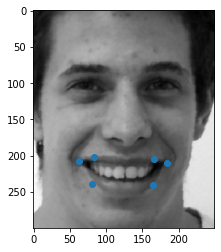

In [ ]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

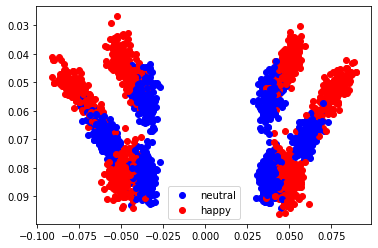

In [ ]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [ ]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.95625 +- 0.006846531968814562
 Average and std test score : 0.9400000000000001 +- 0.021505813167606556


---

Let's plot some images where the best model was wrong. 

**Question**: Comment the results. Why did the algorithm make a mistake ? Would you choose other landmarks ? Try at least another combination of landmarks

**Answer**: The model is too simple and underfitted. We can see on the failures that the people were happy but the chosen lips landmarks shape remained the same as in neutral state, meaning their happiness was expressed by other features not described by the model.

Adding some more landmarks of mouth and the first ten landmarks (I choose them by chance) provided better performance.




---

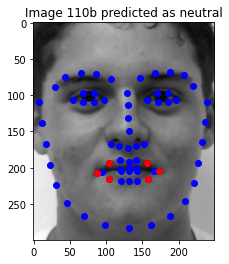

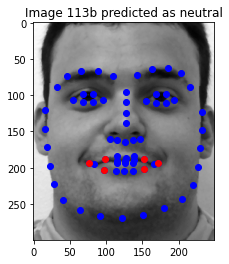

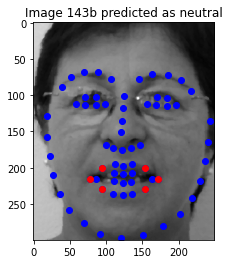

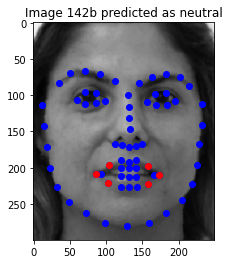

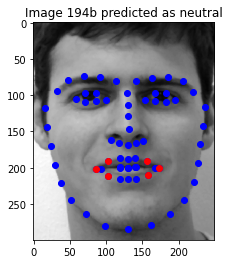

In [ ]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 

Number of subjects N is:  400  ; number of features is:  44


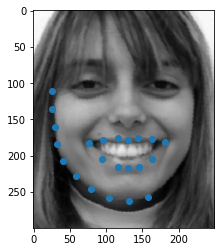

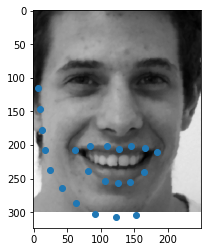

Fitting LDA
 Average and std train score : 0.9806250000000001 +- 0.003061862178478962
 Average and std test score : 0.9549999999999998 +- 0.012747548783981964


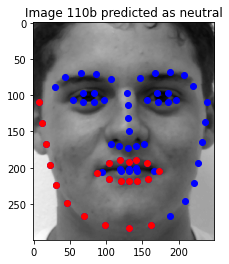

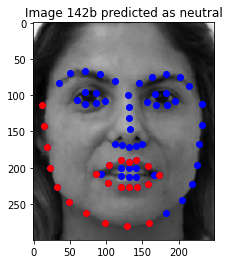

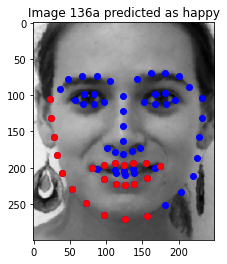

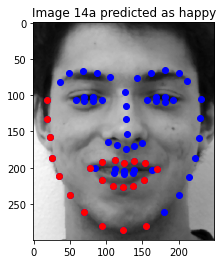

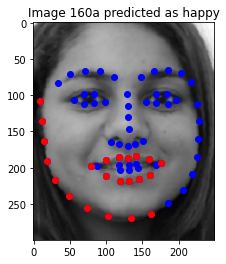

In [ ]:
# Select lateral landmarks mouth
select_land=[49,50,51,52,53,54,55,56,57,58,59,60,1,2,3,4,5,6,7,8,9,10]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()




---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [ ]:
# Fitting K-nearest neighbour with Nested Cross-Validation
 
print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV
done in 1.861s
Average and std Nested Cv train score : 0.968125 +- 0.01658312395177699
Average and std Nested Cv test score : 0.925 +- 0.011180339887498959


---

**Question**: Are Training and Test scores similar ? What does it mean ?

**Answer**: Test score is a slightly lower than train score. This means that the model overfits the data, but no by a high margin.

---

**Question**: Please propose at least another set of features using landmarks and/or pixel intensities of the images and test its discriminative power

**Answer**: The proposed feature is the normalized distance of each landmark to the (0,0) position. This proves to be a better feature than the distance to average porision but a worse feature than the combined distance. 

In [ ]:
# Compute distances from the (0,0) position (features)
dist_zero =np.zeros((N,M))

x_avg=Xmean[::2]
y_avg=Xmean[1::2]

xy_zero = np.array([[0,0] for j in range(M)])

for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    xy = np.array([[x[j],y[j]] for j in range(M)])
    dist_zero[i] = paired_distances(xy,xy_zero)
    


In [ ]:
# fits with initial data
print ("Working with distance to zero features: ")
many_fittings(dist_zero,Yp)

Working with distance to zero features: 
Fitting LDA
done in 0.055s
 Average and std CV score : 0.945 +- 0.01870828693386972
Fitting QDA
done in 0.041s
 Average and std CV score : 0.8875 +- 0.0570087712549569
Fitting Logistic Regression
done in 0.032s
 Average and std CV score : 0.9025000000000001 +- 0.04568916720624269
Fitting Naive-Bayes
done in 0.011s
 Average and std CV score : 0.9225 +- 0.02669269563007827
Fitting K-nearest neighbour
done in 0.064s
 Average and std CV score : 0.9075000000000001 +- 0.03674234614174768
